In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [47]:
caminho = '/content/drive/MyDrive/Modulo11/Jef/monthly-beer-production-in-austr.csv'
df = pd.read_csv(caminho)
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [48]:
# 4. Preparar dados para o Prophet
df['Month'] = pd.to_datetime(df['Month'])
df.rename(columns={'Month': 'ds', 'Monthly beer production': 'y'}, inplace=True)


In [49]:
# Dividindo em treino e teste
train = df[:-24]
test = df[-24:]

In [50]:
# 5. Criar e treinar o modelo Prophet
modelo = Prophet()
modelo.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1v0_38sf/4gysht1c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1v0_38sf/te9d5_f9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71706', 'data', 'file=/tmp/tmp1v0_38sf/4gysht1c.json', 'init=/tmp/tmp1v0_38sf/te9d5_f9.json', 'output', 'file=/tmp/tmp1v0_38sf/prophet_model1rlqhq93/prophet_model-20250407132758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:27:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:27:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [51]:
# 6. Criar dataframe futuro para previsões (ex: 24 meses)
futuro = modelo.make_future_dataframe(periods=24, freq='MS')


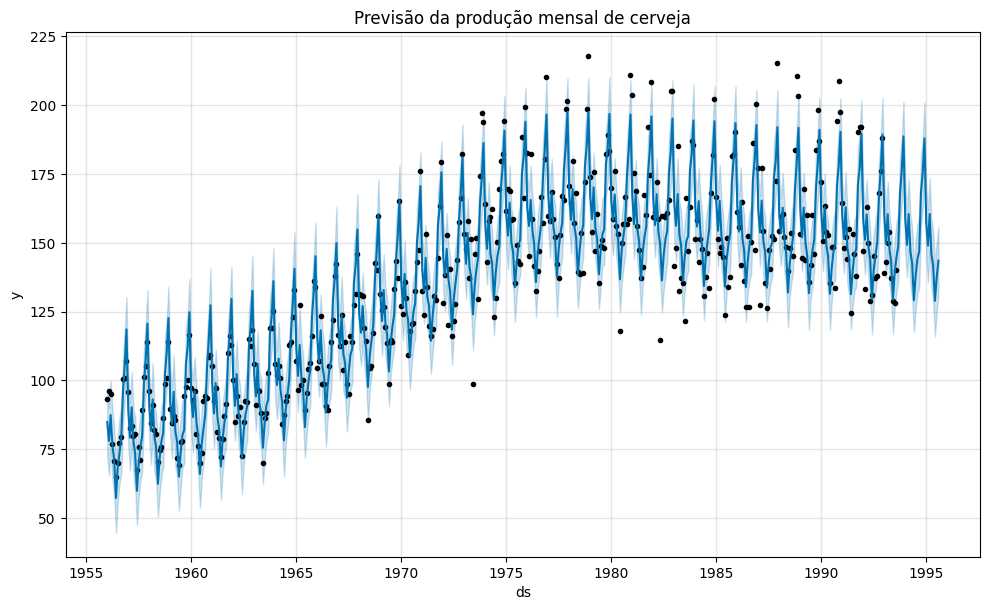

In [52]:
# 7. Gerar previsões
previsao = modelo.predict(futuro)

# Visualizar previsão
modelo.plot(previsao)
plt.title('Previsão da produção mensal de cerveja')
plt.show()


In [53]:
# 8. Exibir a tabela com as previsões (últimos 24 meses)
previsao_tabela = previsao[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24)
previsao_tabela.reset_index(drop=True, inplace=True)
previsao_tabela.head()


,ds,yhat,yhat_lower,yhat_upper
0,1993-09-01,148.652057,135.910507,160.496275
1,1993-10-01,167.514202,156.160110,180.939583
2,1993-11-01,176.080840,163.978490,188.220424
3,1993-12-01,188.573685,175.363954,201.076932
4,1994-01-01,158.669948,146.116778,171.604565


In [54]:
# Preparar previsões para comparação com o conjunto de teste
previsao = previsao.set_index('ds')
test = test.set_index('ds')
prev_test = previsao.loc[test.index][['yhat']]


In [55]:
# Normalizando os dados
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['y']])

# Criando sequências para LSTM
def create_sequences(data, seq_length=12):
    x, y = [], []
    for i in range(len(data)-seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 12
X, y_seq = create_sequences(data_scaled, seq_length)

# Separando treino/teste
X_train, X_test = X[:-24], X[-24:]
y_train, y_test = y_seq[:-24], y_seq[-24:]

# Modelo LSTM
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=50, verbose=0)

# Previsões
y_pred = model_lstm.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


In [57]:
from sklearn.metrics import mean_absolute_error

# Prophet
mae_prophet = mean_absolute_error(test['y'], prev_test['yhat'])

# LSTM
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"MAE Prophet: {mae_prophet:.2f}")
print(f"MAE LSTM: {mae_lstm:.2f}")


MAE Prophet: 9.70
MAE LSTM: 8.79
